In [1]:
from astropy.coordinates import EarthLocation, AltAz, SkyCoord, GCRS
from astropy import units as u
from astropy.time import Time
import numpy as np
from datetime import datetime, timedelta

start_time = datetime(2025, 2, 21, 12, 0, 0)
current_time = start_time

vla = EarthLocation.of_site('vla')
source = SkyCoord(ra=10*u.hourangle, dec=-30*u.deg, frame='icrs')

antenna_1_pos = np.array([0,0,0])
antenna_2_pos = np.array([10,200,10])

# ENU coordinates
baseline = antenna_2_pos - antenna_1_pos

# convert to x,y,z coordinates where z points to the NCP
# we need the latitude of the site
# y will point locally eastward
# z aligns with NCP
# think of projection of NU axes onto z.
# x is y X z
latitude = vla.lat
transform_enu_xyz = np.array([
    [0, -np.sin(latitude), np.cos(latitude)], 
    [1, 0, 0], 
    [0, np.cos(latitude), np.sin(latitude)]
])
baseline_xyz = np.matmul(transform_enu_xyz, baseline)

obs_frequency = 1_000_000
obs_wavelength = 3.0 * 10**8 / obs_frequency 

14h57m10.31672278s
4h57m10.31672278s
14h58m10.48099765s
4h58m10.48099765s
14h59m10.64527252s
4h59m10.64527252s
15h00m10.80954738s
5h00m10.80954738s
15h01m10.97382225s
5h01m10.97382225s
15h02m11.13809712s
5h02m11.13809712s
15h03m11.30237198s
5h03m11.30237198s
15h04m11.46664685s
5h04m11.46664685s
15h05m11.63092172s
5h05m11.63092172s
15h06m11.79519658s
5h06m11.79519658s
15h07m11.95947145s
5h07m11.95947145s
15h08m12.12374632s
5h08m12.12374632s
15h09m12.28802118s
5h09m12.28802118s
15h10m12.45229605s
5h10m12.45229605s
15h11m12.61657092s
5h11m12.61657092s
15h12m12.78084578s
5h12m12.78084578s
15h13m12.94512065s
5h13m12.94512065s
15h14m13.10939552s
5h14m13.10939552s
15h15m13.27367039s
5h15m13.27367039s
15h16m13.43794525s
5h16m13.43794525s
15h17m13.60222012s
5h17m13.60222012s
15h18m13.76649499s
5h18m13.76649499s
15h19m13.93076985s
5h19m13.93076985s
15h20m14.09504472s
5h20m14.09504472s
15h21m14.25931959s
5h21m14.25931959s
15h22m14.42359445s
5h22m14.42359445s
15h23m14.58786932s
5h23m14.58786932s
1

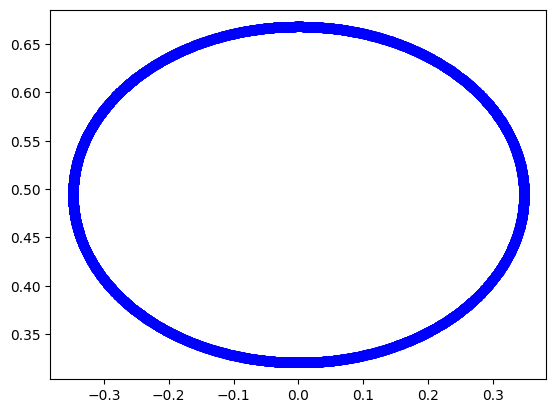

In [2]:
import matplotlib.pyplot as plt

uvs = []

for i in range(6000):
    current_time = current_time + timedelta(minutes=1)
    obs_time = Time(current_time.isoformat(), location=vla)
    obs_local_sidereal_time = obs_time.sidereal_time(kind='mean')
    hour_angle = obs_local_sidereal_time - source.ra
    
    # taken from slides
    # u points eastward
    # w tracks source
    # v is the remaining x-product
    transform_xyz_uvw = np.array([
    [np.sin(hour_angle), np.cos(hour_angle), 0],
    [-np.sin(source.dec) * np.cos(hour_angle), np.sin(source.dec) * np.sin(hour_angle), np.cos(source.dec)],
    [np.cos(hour_angle) * np.cos(source.dec), np.sin(hour_angle) * np.cos(source.dec), np.sin(source.dec)]    
])
    baseline_uvw = np.matmul(transform_xyz_uvw, baseline_xyz) / obs_wavelength
    uvs.append(baseline_uvw[:2])

uvs = np.array(uvs)

plt.scatter(uvs[:,0], uvs[:,1], color='blue')

plt.show()


In [3]:
source.ra 
10 * 15

150